# Cyber Security Tweet Analysis

In [67]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline 

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist

from sklearn.preprocessing import MinMaxScaler

## Functions

In [2]:
#Creating a function that takes in a range of values for K (or how many clusters)
# runs the model and then outputs the inertia value so we can see how well the clusters are grouped 


def evaluate_k_kmeans_inertia(k, vec):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(vec)
    return estimator_kmeans.inertia_

In [3]:
def splitData(data, len_of_frame):
    n = len(data.index) 
    split_n = round(n/len_of_frame, 0)
    print(split_n)
    splits = [int(x) for x in range(int(split_n))]
    lst = []
    for splt in splits:
        if splt == splits[-1]:
            lst.append(data[int(splt * len_of_frame):])
        else:
            lst.append(data[int(splt * len_of_frame):int(len_of_frame * (1 + splt))])
    return lst

In [4]:
def cluster_summary(ci, df):
    cluster = df[df.cluster_id==ci]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [5]:
# we can make a function that puts comparisons side by side so its easier for us to see in a data frame 

def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id, ident))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [6]:
def kmeans_cluster(df, n_clusters=2):
    """This function assigns clusters to every row in the dataframe via kmeans"""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [7]:
def graph_summary_clustering(results):
    """this function produces a summary of the clusters"""
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

In [8]:
def mainWords(cluster_data):
    main = []
    n = len(cluster_data.index) 
    for col in cluster_data.columns:
        if cluster_data[col].sum() > float(n/3):
            main += [col]
    return main

In [9]:
def findText(cluster_data):
    text_dict = {}
    text_dict['text'] = []
    text_dict['user_id'] = []
    ids_lst =  list(cluster_data.user_id)
    for ids in data['user_id']:
        if ids in ids_lst:
            for row in data[data.user_id == ids]['text']:
                text_dict['text'] += [row]
                text_dict['user_id'] += [ids]
    dataframe = pd.DataFrame(text_dict)
    cleanframe = dataframe.drop_duplicates(['text', 'user_id'])
    return cleanframe

# Data

In [10]:
data = pd.read_csv('cybersec_processed.csv', parse_dates=True)
data.head() # extra columns that I dont know got here 

,Unnamed: 0,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,...,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,year_account_created
0,0.0,x109082290,x1404488925935177737,2021-06-14 17:20:28,NcsVentures,sign cause solution network data breach cyber...,WordPress.com,109,NaN,NaN,...,2010-01-27 22:48:24,False,https://t.co/E0XpJWVD52,http://www.nationalcybersecurity.com/,NaN,https://pbs.twimg.com/profile_banners/10908229...,http://abs.twimg.com/images/themes/theme15/bg.png,http://pbs.twimg.com/profile_images/715854922/...,14.0,2010.0
1,1.0,x109082290,x1403635112613494786,2021-06-12 08:47:43,NcsVentures,battling chinese big tech encroachment india ...,WordPress.com,103,NaN,NaN,...,2010-01-27 22:48:24,False,https://t.co/E0XpJWVD52,http://www.nationalcybersecurity.com/,NaN,https://pbs.twimg.com/profile_banners/10908229...,http://abs.twimg.com/images/themes/theme15/bg.png,http://pbs.twimg.com/profile_images/715854922/...,12.0,2010.0
2,2.0,x109082290,x1403747937818120198,2021-06-12 16:16:03,NcsVentures,ask dr jeanette success way devil choke chain ...,WordPress.com,226,NaN,NaN,...,2010-01-27 22:48:24,False,https://t.co/E0XpJWVD52,http://www.nationalcybersecurity.com/,NaN,https://pbs.twimg.com/profile_banners/10908229...,http://abs.twimg.com/images/themes/theme15/bg.png,http://pbs.twimg.com/profile_images/715854922/...,12.0,2010.0
3,3.0,x109082290,x1404021845913899009,2021-06-13 10:24:28,NcsVentures,threat digital pakistan cyberattack,WordPress.com,89,NaN,NaN,...,2010-01-27 22:48:24,False,https://t.co/E0XpJWVD52,http://www.nationalcybersecurity.com/,NaN,https://pbs.twimg.com/profile_banners/10908229...,http://abs.twimg.com/images/themes/theme15/bg.png,http://pbs.twimg.com/profile_images/715854922/...,13.0,2010.0
4,4.0,x109082290,x1404053089804554241,2021-06-13 12:28:37,NcsVentures,pakistan attack news pakistan army claim major...,WordPress.com,152,NaN,NaN,...,2010-01-27 22:48:24,False,https://t.co/E0XpJWVD52,http://www.nationalcybersecurity.com/,NaN,https://pbs.twimg.com/profile_banners/10908229...,http://abs.twimg.com/images/themes/theme15/bg.png,http://pbs.twimg.com/profile_images/715854922/...,13.0,2010.0


In [11]:
data[data["Unnamed: 0"].isna()]

,Unnamed: 0,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,...,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,day_post_created,year_account_created
4724,NaN,Marky_Sparky_Twerpy_action,131,NaN,NaN,NaN,False,False,0,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN
4726,NaN,Marky_Sparky_Twerpy_action,105,NaN,NaN,NaN,False,False,0,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN
4728,NaN,Marky_Sparky_Twerpy_action,95,NaN,NaN,NaN,False,False,1,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN
4730,NaN,Marky_Sparky_Twerpy_action,116,NaN,NaN,NaN,False,False,0,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN
4733,NaN,Marky_Sparky_Twerpy_action,125,NaN,NaN,NaN,False,False,0,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN
4735,NaN,Marky_Sparky_Twerpy_action,83,NaN,NaN,NaN,False,False,0,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN
4737,NaN,Marky_Sparky_Twerpy_action,117,NaN,NaN,NaN,False,False,0,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN
4739,NaN,Marky_Sparky_Twerpy_action,122,NaN,NaN,NaN,False,False,0,0,...,https://pbs.twimg.com/profile_banners/34316037...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1227691993...,14,2015.0,NaN,NaN,NaN,NaN,NaN


In [12]:
data = data.drop(labels = [4724, 4726, 4728, 4730, 4733, 4735, 4737, 4739], axis = 0)

In [13]:
data.shape

(17656, 93)

In [14]:
data.columns

Index(['Unnamed: 0', 'user_id', 'status_id', 'created_at', 'screen_name',
       'text', 'source', 'display_text_width', 'reply_to_status_id',
       'reply_to_user_id', 'reply_to_screen_name', 'is_quote', 'is_retweet',
       'favorite_count', 'retweet_count', 'quote_count', 'reply_count',
       'hashtags', 'symbols', 'urls_url', 'urls_t.co', 'urls_expanded_url',
       'media_url', 'media_t.co', 'media_expanded_url', 'media_type',
       'ext_media_url', 'ext_media_t.co', 'ext_media_expanded_url',
       'ext_media_type', 'mentions_user_id', 'mentions_screen_name', 'lang',
       'quoted_status_id', 'quoted_text', 'quoted_created_at', 'quoted_source',
       'quoted_favorite_count', 'quoted_retweet_count', 'quoted_user_id',
       'quoted_screen_name', 'quoted_name', 'quoted_followers_count',
       'quoted_friends_count', 'quoted_statuses_count', 'quoted_location',
       'quoted_description', 'quoted_verified', 'retweet_status_id',
       'retweet_text', 'retweet_created_at', 'ret

In [15]:
from datetime import datetime
data['created_at'] = data[["created_at"]].apply(pd.to_datetime)
data['created_at'] = data['created_at'].apply(datetime.date)
data[['created_at']]

,created_at
0,2021-06-14
1,2021-06-12
2,2021-06-12
3,2021-06-13
4,2021-06-13
...,...
17659,2021-06-11
17660,2021-06-11
17661,2021-06-11
17662,2021-06-11


In [16]:
text = data[['text', 'created_at']]
text.drop_duplicates('text')
text.head()

,text,created_at
0,sign cause solution network data breach cyber...,2021-06-14
1,battling chinese big tech encroachment india ...,2021-06-12
2,ask dr jeanette success way devil choke chain ...,2021-06-12
3,threat digital pakistan cyberattack,2021-06-13
4,pakistan attack news pakistan army claim major...,2021-06-13


In [17]:
text.shape

(17656, 2)

# EDA

## Country

In [18]:
countries = data[['country', 'text', 'user_id']].drop_duplicates('user_id')

In [19]:
fdist_country = FreqDist()

for country in countries['country']:
    fdist_country[country]+=1
fdist_country 

FreqDist({'United States': 2439, 'Unknown': 2214, 'United Kingdom': 743, 'India': 527, 'Canada': 227, 'Global': 138, 'Australia': 109, 'France': 84, 'Deutschland': 67, 'Éire / Ireland': 61, ...})

In [20]:
fdist_country.most_common(20)

[('United States', 2439),
 ('Unknown', 2214),
 ('United Kingdom', 743),
 ('India', 527),
 ('Canada', 227),
 ('Global', 138),
 ('Australia', 109),
 ('France', 84),
 ('Deutschland', 67),
 ('Éire / Ireland', 61),
 ('Italia', 56),
 ('South Africa', 54),
 ('الإمارات العربية المتحدة', 50),
 ('Nigeria', 38),
 ('Colombia', 37),
 ('España', 35),
 ('Nederland', 35),
 ('Schweiz/Suisse/Svizzera/Svizra', 32),
 ('Brasil', 29),
 ('Singapore', 28)]

In [21]:
fdist_country["United Arab Emirates"] = fdist_country.pop("الإمارات العربية المتحدة")
fdist_country["Lebanon"] = fdist_country.pop("لبنان")
fdist_country["Germany"] = fdist_country.pop("Deutschland")
fdist_country["Switzerland"] = fdist_country.pop("Schweiz/Suisse/Svizzera/Svizra")

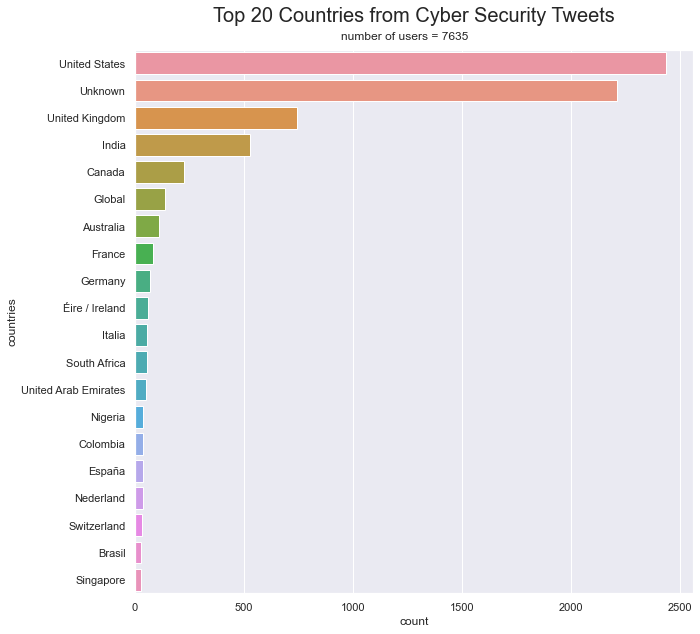

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
freq_data_country = pd.DataFrame.from_dict(fdist_country.most_common(20))
sns.barplot(data = freq_data_country, x = 1, y = 0)
plt.title("Top 20 Countries from Cyber Security Tweets", size = 20, y = 1.04)
plt.suptitle("number of users = 7635", y = 0.905)
plt.xlabel("count")
plt.ylabel("countries");

## Retweet Count

In [27]:
retweet_cnt = data[['retweet_count']].astype("float64")
retweet_cnt.head()

,retweet_count
0,0.0
1,4.0
2,3.0
3,2.0
4,2.0


In [28]:
rt_over25 = data[data.retweet_count.astype('float64') >= 50][['retweet_count']]
rt_over25.head()

,retweet_count
951,55
2935,56
2939,53
2950,68
2952,55


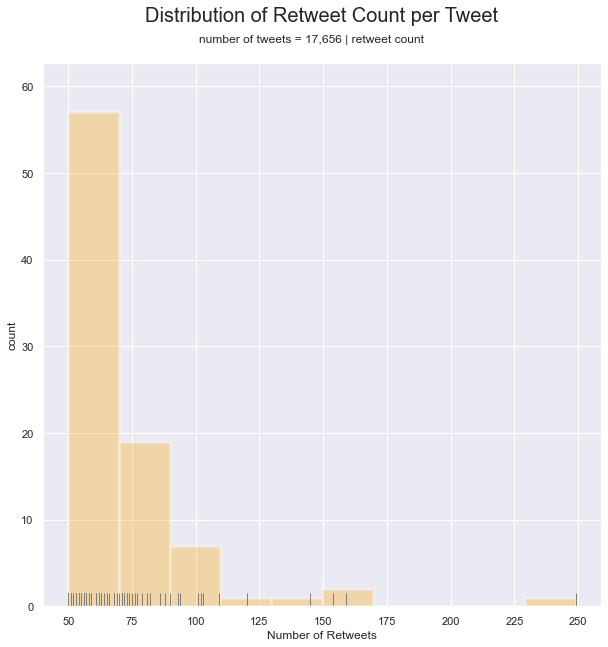

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
sns.distplot(rt_over25.retweet_count, kde = False, color = 'gray',  hist_kws={"linewidth": 3, "alpha": .3, "color": "orange"}, rug = True, bins = 10)
plt.title("Distribution of Retweet Count per Tweet", y = 1.065, size = 20)
plt.suptitle("number of tweets = 17,656 | retweet count ", y = .92)
plt.xlabel("Number of Retweets")
plt.ylabel("count");

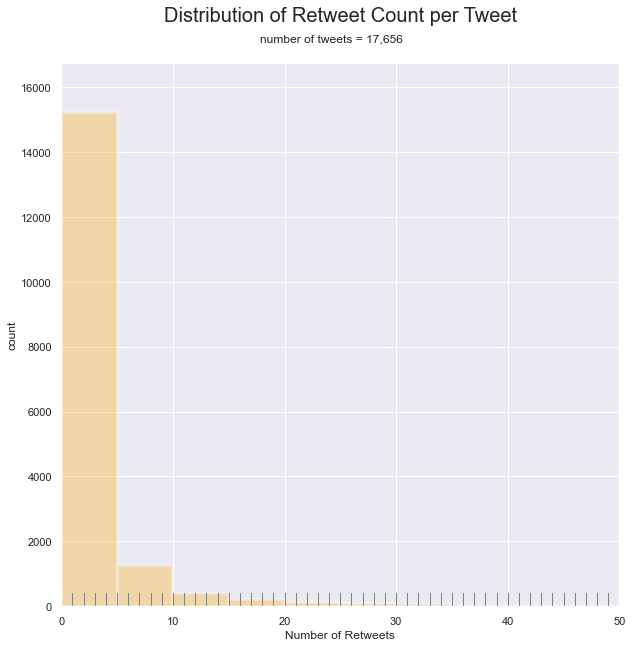

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
sns.distplot(retweet_cnt.retweet_count, kde = False, color = 'gray',  hist_kws={"linewidth": 3, "alpha": .3, "color": "orange"}, rug = True)
plt.title("Distribution of Retweet Count per Tweet", y = 1.065, size = 20)
plt.suptitle("number of tweets = 17,656", y = .92)
plt.xlabel("Number of Retweets")
plt.ylabel("count")
plt.xlim((0, 50));

In [31]:
over5_rts = data[data.retweet_count.astype("float64") > 10][['text', 'retweet_count', "followers_count", "verified", "description"]]
over5_rts.head()

,text,retweet_count,followers_count,verified,description
944,10 step educate company ai fairness\r\n\r\n,47,2044,False,u0001f4da passionate programming artificial in...
945,company keep ai digital transformation plans\r...,28,2044,False,u0001f4da passionate programming artificial in...
946,usaxoom\r\nworldwide best smm seo service prov...,12,2044,False,u0001f4da passionate programming artificial in...
947,eco bike charging city concept\r\nartificialin...,20,2044,False,u0001f4da passionate programming artificial in...
948,nft aka new fashion technology\r\nrelay switch...,14,2044,False,u0001f4da passionate programming artificial in...


In [32]:
rts_words = []

for row in over5_rts['text']:
    for word in str(row).split(" "):
        rts_words.append(word)
        
rts_words[:5]

['10', 'step', 'educate', 'company', 'ai']

In [33]:
fdist_over5 = FreqDist()
for word in rts_words:
    fdist_over5[word]+=1
fdist_over5

FreqDist({'ai': 333, '100daysofcode': 299, 'javascript': 296, 'machinelearning': 279, 'python': 269, 'serverless': 249, 'datascience': 248, 'iot': 246, 'flutter': 203, 'ml': 169, ...})

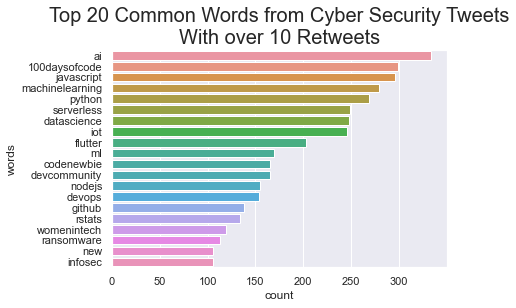

In [34]:
freq_data_over5 = pd.DataFrame.from_dict(fdist_over5.most_common(20))
sns.barplot(data = freq_data_over5, x = 1, y = 0)
plt.title("Top 20 Common Words from Cyber Security Tweets" + "\n" + "With over 10 Retweets", size = 20)
#plt.suptitle("With over 10 Retweets", y = .9)
plt.xlabel("count")
plt.ylabel("words");

## Followers Count 

In [35]:
followers = data[['followers_count', 'user_id']].drop_duplicates('user_id')
followers.head()

,followers_count,user_id
0,8524,x109082290
459,7288,x194297917
918,0,x1404297347950071818
919,82,x4439325029
921,52913,x821567125785612288


In [36]:
followers["new_fol_col"] = followers["followers_count"].astype("float64")
followers.head()

,followers_count,user_id,new_fol_col
0,8524,x109082290,8524.0
459,7288,x194297917,7288.0
918,0,x1404297347950071818,0.0
919,82,x4439325029,82.0
921,52913,x821567125785612288,52913.0


In [37]:
mean_fol = followers['followers_count'].astype('float64').mean()

In [38]:
followers['diff_from_mean'] = followers['new_fol_col'] - mean_fol

In [39]:
followers.shape

(7635, 4)

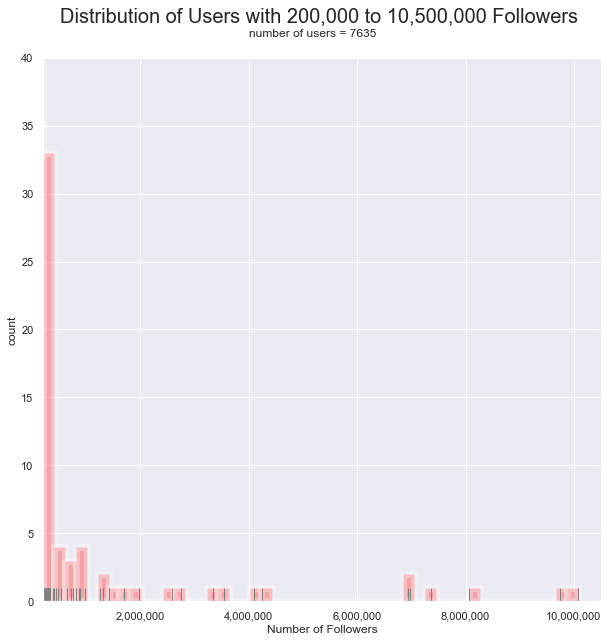

In [101]:
fig, ax = plt.subplots(figsize=(10,10))
sns.distplot(followers['new_fol_col'], norm_hist = False, kde = False, rug = True, color = "gray",
            hist_kws={"linewidth": 7, "color": "red", "alpha": .3,})
plt.title("Distribution of Users with 200,000 to 10,500,000 Followers ", y = 1.055, size = 20)
plt.suptitle("number of users = 7635", y = .92);
plt.xlabel("Number of Followers")
plt.ylabel("count")
plt.xlim((200000, 10500000))
plt.ylim((0,40))
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

#ax.xaxis.set_major_formatter(FormatStrFormatter('{:,}'));

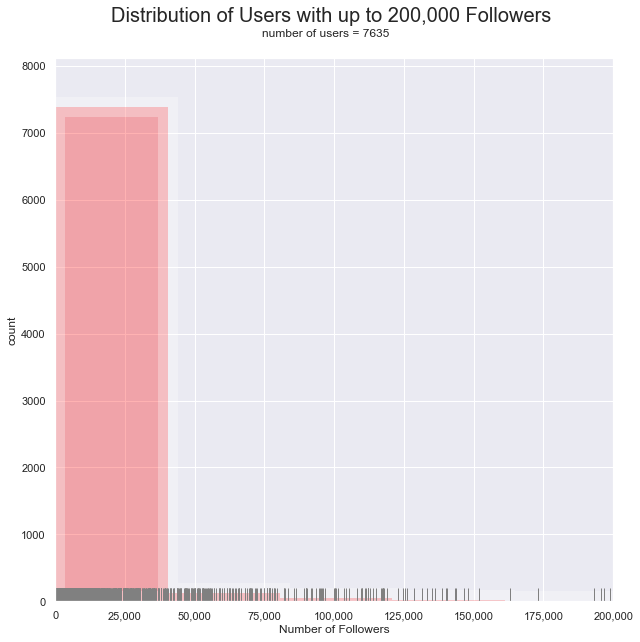

In [117]:
fig, ax = plt.subplots(figsize=(10,10))
sns.distplot(followers['new_fol_col'], norm_hist = False, kde = False, rug = True, color = "gray",
            hist_kws={"histtype": "stepfilled", "linewidth": 20, "color": "red", "alpha": .3,}, bins = 500)
plt.title("Distribution of Users with up to 200,000 Followers ", y = 1.055, size = 20)
plt.suptitle("number of users = 7635", y = .92);
plt.xlabel("Number of Followers")
plt.ylabel("count")
plt.xlim((0, 200000))
#plt.ylim((0,40))
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [108]:
followers['followers_count'].astype('float64').max()

10072025.0

## Hashtags

In [496]:
hashs = data[["hashtags"]].dropna()
hashs

,hashtags
0,cybersecurity cyberattack
1,cybersecurity cyberattack
2,cybersecurity cyberattack
3,cybersecurity cyberattack
4,cybersecurity cyberattack
...,...
17658,Delhi DelhiPolice cybercrime cybersecurity tra...
17660,cybersecurity cyberattacks informationsecurity...
17661,CyberSecurity Computing DataScience MachineLea...
17662,PKI PrimeKey EJBCA Cybersecurity


In [506]:
def removeCybersec(txt):
    txt_lst = txt.lower().split()
    if "cybersecurity" in txt_lst:
        txt_lst.remove("cybersecurity")
    return " ".join(txt_lst)
          

In [509]:
hashs['hashtags'] = hashs['hashtags'].apply(removeCybersec)

In [510]:
hashs.head()

,hashtags,hastags
0,cyberattack,cyberattack
1,cyberattack,cyberattack
2,cyberattack,cyberattack
3,cyberattack,cyberattack
4,cyberattack,cyberattack


In [511]:
hash_words = []

for row in hashs['hashtags']:
    for word in str(row).split(" "):
        hash_words.append(word)
        
hash_words[:5]

['cyberattack', 'cyberattack', 'cyberattack', 'cyberattack', 'cyberattack']

In [517]:
hash_words = [word for word in hash_words if word != '']

In [518]:
fdist_hash = FreqDist()
for word in hash_words:
    fdist_hash[word]+=1
fdist_hash

FreqDist({'infosec': 3236, 'security': 2153, 'cyberattack': 1283, 'ransomware': 1212, 'iot': 1148, 'ai': 1029, '100daysofcode': 960, 'malware': 911, 'technology': 847, 'hacking': 834, ...})

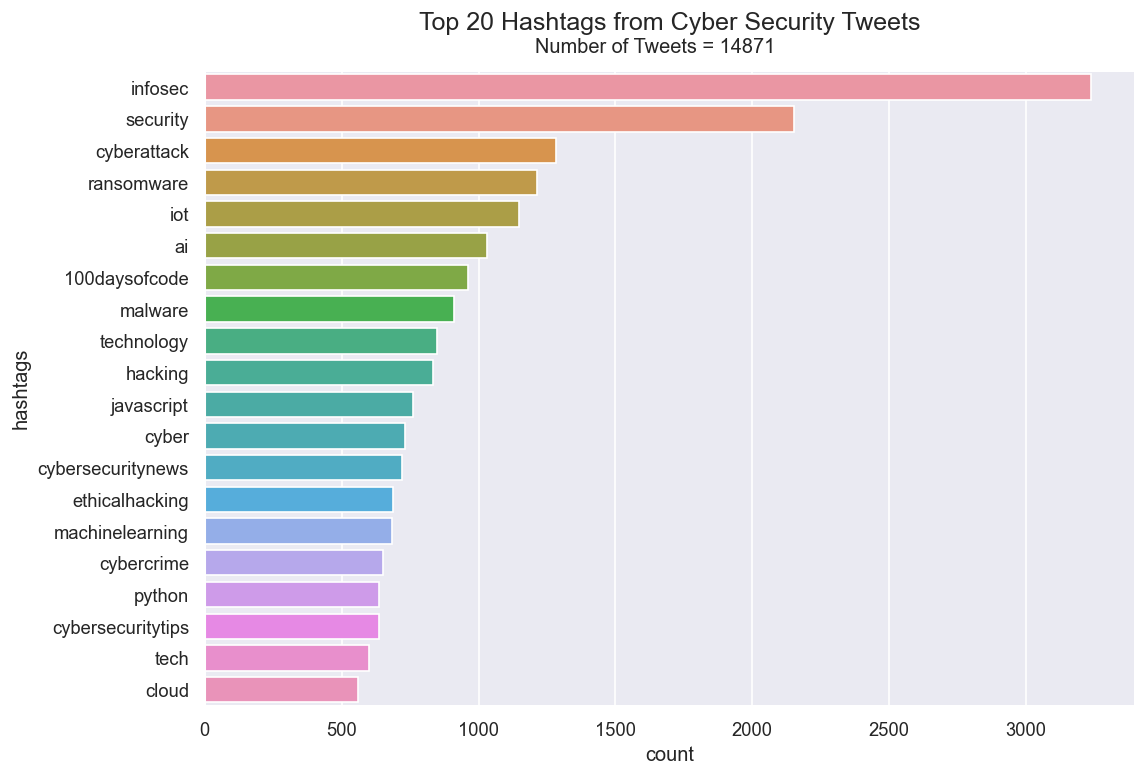

In [528]:
freq_data_hash = pd.DataFrame.from_dict(fdist_hash.most_common(20))
sns.barplot(data = freq_data_hash, x = 1, y = 0)
plt.title("Top 20 Hashtags from Cyber Security Tweets", size = 15, y = 1.05)
plt.suptitle("Number of Tweets = 14871", y = .92)
plt.xlabel("count")
plt.ylabel("hashtags");

## Year Account Created / Age of Account

In [110]:
acc_created = data[['year_account_created', 'text']]
acc_created.head()

,year_account_created,text
0,2010.0,sign cause solution network data breach cyber...
1,2010.0,battling chinese big tech encroachment india ...
2,2010.0,ask dr jeanette success way devil choke chain ...
3,2010.0,threat digital pakistan cyberattack
4,2010.0,pakistan attack news pakistan army claim major...


In [111]:
acc_created['age_of_account'] = 2021 - acc_created['year_account_created']
acc_created.head()

,year_account_created,text,age_of_account
0,2010.0,sign cause solution network data breach cyber...,11.0
1,2010.0,battling chinese big tech encroachment india ...,11.0
2,2010.0,ask dr jeanette success way devil choke chain ...,11.0
3,2010.0,threat digital pakistan cyberattack,11.0
4,2010.0,pakistan attack news pakistan army claim major...,11.0


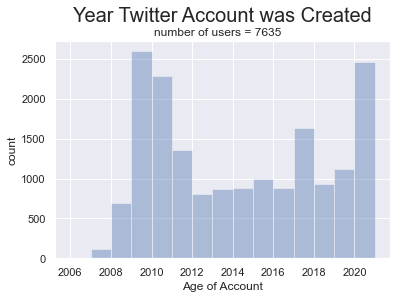

In [112]:
sns.distplot(acc_created['year_account_created'],  kde = False, bins =15)
plt.title("Year Twitter Account was Created", size = 20, y = 1.06)
plt.suptitle("number of users = 7635", y = .925)
plt.xlabel("Age of Account")
plt.ylabel("count");

## Is Verified 

In [727]:
veri = data[["verified", "user_id", "text", "description"]].drop_duplicates('user_id')
veri.head()

,verified,user_id,text,description
0,False,x109082290,sign cause solution network data breach cyber...,leader news hacker hacking techjobs nationalcy...
459,False,x194297917,mysterious malware stole data 325 million wind...,gregory evans mogul founder nationalcybersecur...
918,False,x1404297347950071818,free course training usa beginner,NaN
919,False,x4439325029,stake high ceo need get involved pwc seanmjoyc...,NaN
921,False,x821567125785612288,today complex working environment line home of...,iiotworld first global digitalpublication focu...


In [728]:
#veri.verified = veri.verified.apply(lambda x: True if (x  == 'True') else False )

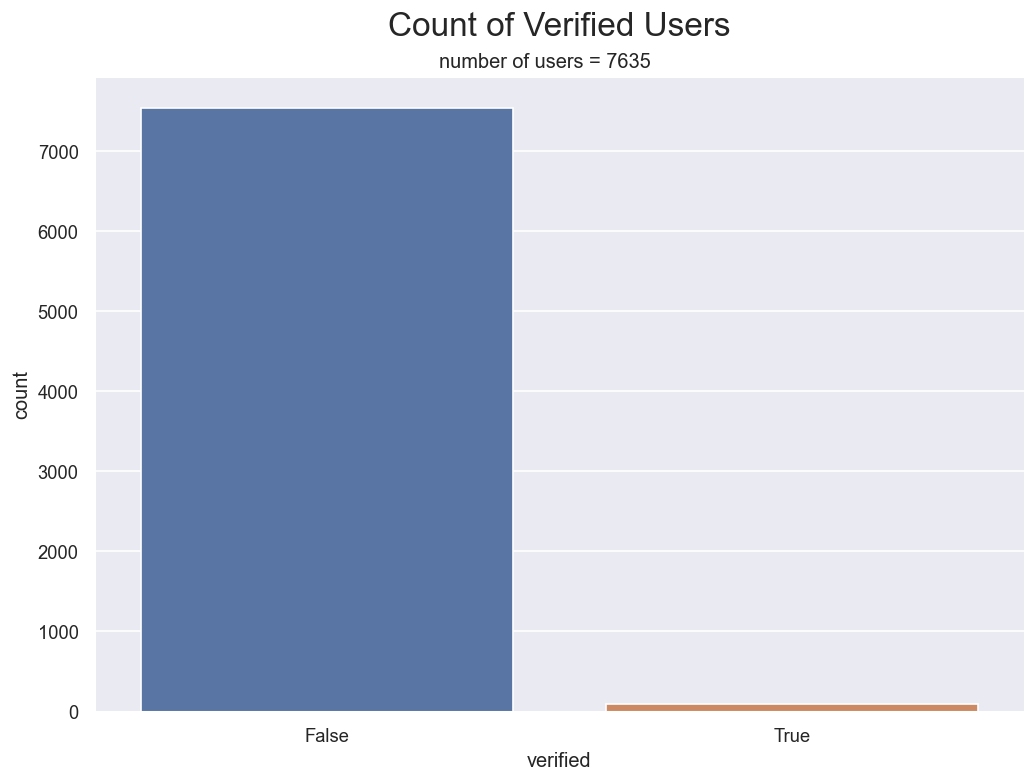

In [732]:
sns.countplot(veri.verified, )
plt.title("Count of Verified Users", size = 20, y = 1.05)
plt.suptitle("number of users = 7635", y = .91);

In [725]:
veri.shape

(7635, 4)

### Word Frequency 

In [16]:
cs_words = []

for row in text['text']:
    for word in str(row).split(" "):
        cs_words.append(word)
        
cs_words[:5]

['sign', 'cause', 'solution', 'network', 'data']

In [17]:
len(cs_words)

231447

In [18]:
fdist = FreqDist()
for word in cs_words:
    fdist[word]+=1
fdist

FreqDist({'data': 1545, 'new': 1537, 'attack': 1400, 'infosec': 1333, 'ransomware': 1312, 'amp': 1188, 'business': 1039, 'u': 1037, 'threat': 877, 'hacker': 864, ...})

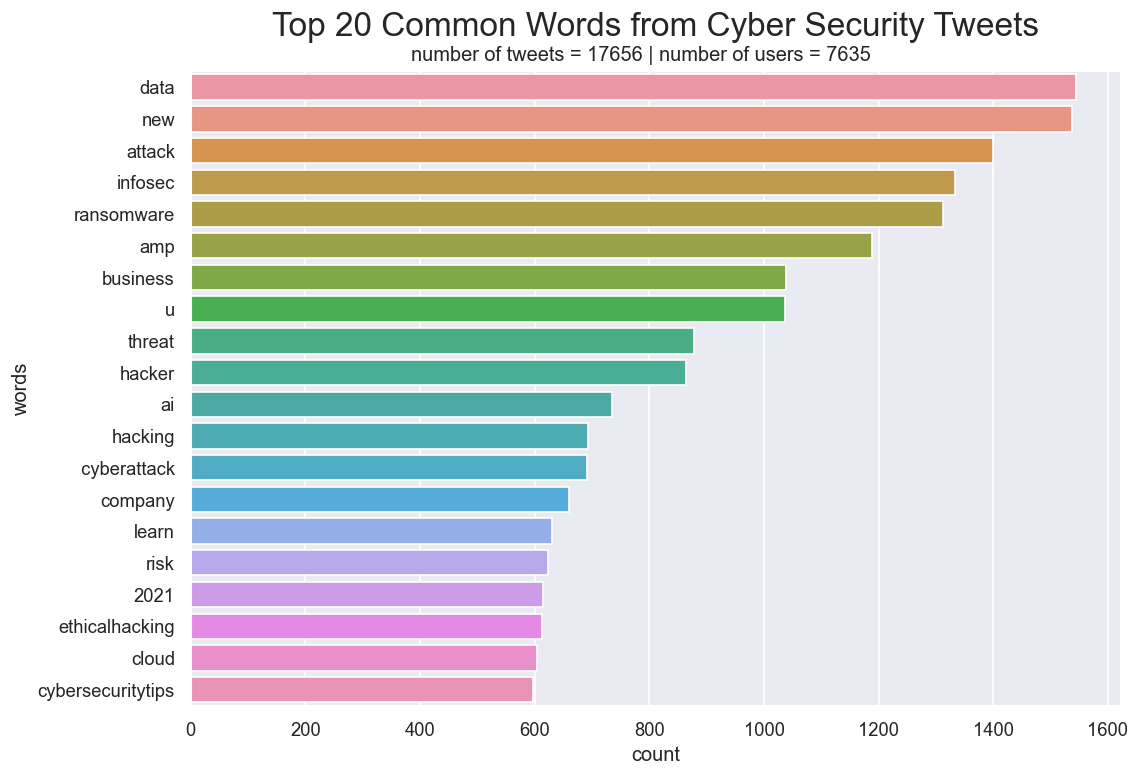

In [743]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))
sns.barplot(data = freq_data, x = 1, y = 0)
plt.title("Top 20 Common Words from Cyber Security Tweets", size = 20, y = 1.04)
plt.suptitle("number of tweets = 17656 | number of users = 7635", y = .91)
plt.xlabel("count")
plt.ylabel("words");

In [20]:
most_common = []

for key in fdist.most_common(25):
    most_common.append(key[0])
    
print(most_common)

['data', 'new', 'attack', 'infosec', 'ransomware', 'amp', 'business', 'u', 'threat', 'hacker', 'ai', 'hacking', '\xa0cyberattack', 'company', 'learn', 'risk', '2021', 'ethicalhacking', 'cloud', 'cybersecuritytips', 'cybersecuritynews', 'iotcybersec24', 'help', 'system', 'need']


In [21]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

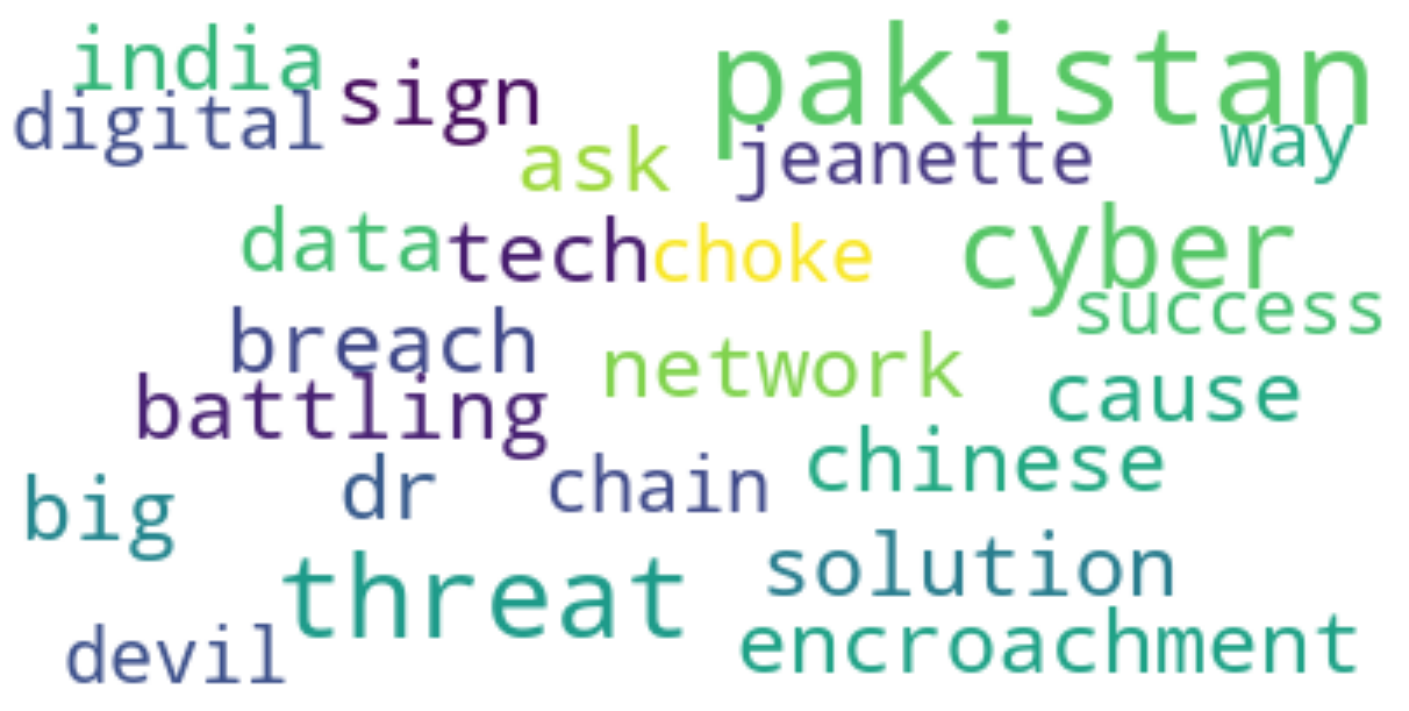

In [22]:
stopwords = set(STOPWORDS)
new_stopwords=stopwords.union(text)
wc = WordCloud(
         background_color="white", max_words=2000, 
         min_font_size =15, max_font_size=40, relative_scaling = 
         0.5, stopwords=new_stopwords,normalize_plurals= True, random_state = 42)
import re 
textonly = re.sub(" ", " ",str(text))
wc.generate(textonly)
plt.figure(figsize=(25,25))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()
# devil is interesting, Intel is possibly the company, 
# Jeanette Manfra is commonly found when searching jeannette
# and cybersecurity
# Microsoft Azure Sentinel is a scalable, cloud-native, security information 
# event management (SIEM) and security orchestration automated response (SOAR) solution. 
# Los Angeles and Pakistan are the only locations, chinese is only nationality

### Sentiment Analysis

In [23]:
sid = SentimentIntensityAnalyzer()
text['scores'] = text['text'].apply(lambda review: sid.polarity_scores(str(review)))
text.head()

,text,created_at,scores
0,sign cause solution network data breach cyber...,2021-06-14,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp..."
1,battling chinese big tech encroachment india ...,2021-06-12,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp..."
2,ask dr jeanette success way devil choke chain ...,2021-06-12,"{'neg': 0.256, 'neu': 0.55, 'pos': 0.194, 'com..."
3,threat digital pakistan cyberattack,2021-06-13,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'comp..."
4,pakistan attack news pakistan army claim major...,2021-06-13,"{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compou..."


In [24]:
text['compound']  = text['scores'].apply(lambda score_dict: score_dict['compound'])
text.head()

,text,created_at,scores,compound
0,sign cause solution network data breach cyber...,2021-06-14,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp...",0.3182
1,battling chinese big tech encroachment india ...,2021-06-12,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",-0.2732
2,ask dr jeanette success way devil choke chain ...,2021-06-12,"{'neg': 0.256, 'neu': 0.55, 'pos': 0.194, 'com...",-0.4404
3,threat digital pakistan cyberattack,2021-06-13,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'comp...",-0.5267
4,pakistan attack news pakistan army claim major...,2021-06-13,"{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compou...",-0.7351


In [25]:
text['comp_score'] = text['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
text.head()

,text,created_at,scores,compound,comp_score
0,sign cause solution network data breach cyber...,2021-06-14,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp...",0.3182,pos
1,battling chinese big tech encroachment india ...,2021-06-12,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",-0.2732,neg
2,ask dr jeanette success way devil choke chain ...,2021-06-12,"{'neg': 0.256, 'neu': 0.55, 'pos': 0.194, 'com...",-0.4404,neg
3,threat digital pakistan cyberattack,2021-06-13,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'comp...",-0.5267,neg
4,pakistan attack news pakistan army claim major...,2021-06-13,"{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compou...",-0.7351,neg


AttributeError: 'DataFrame' object has no attribute 'comp_score'

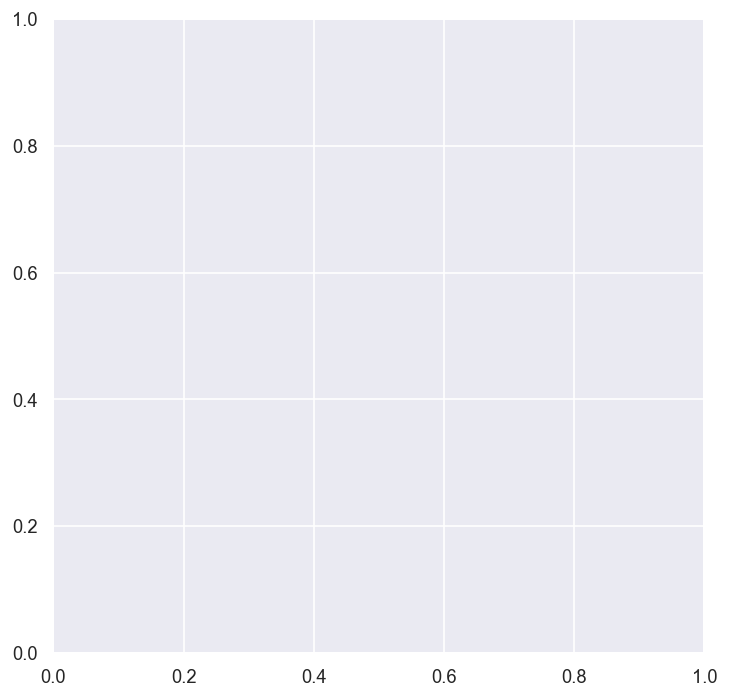

In [737]:
fig, ax = plt.subplots(figsize=(7,7))
comp_score_counts = text.comp_score.value_counts()
comp_score_counts.plot.pie(autopct="%.1f%%")
plt.title("Sentiment Analysis for Cyber Security Tweets", size = 20)
plt.ylabel("compound scores")
plt.suptitle('number of tweets = 17656 | number of users = 7635', size = 10, y = .87);

### Time Series Analysis on Compound Score

In [27]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [28]:
time_series_com = text[['created_at', "compound"]].set_index('created_at')
time_series_com.head()

,compound
created_at,
2021-06-14,0.3182
2021-06-12,-0.2732
2021-06-12,-0.4404
2021-06-13,-0.5267
2021-06-13,-0.7351


In [250]:
time_series_com = time_series_com.groupby('created_at').mean('compound')

In [252]:
time_series_com

,compound
created_at,
2021-06-11,0.093343
2021-06-12,0.042218
2021-06-13,0.056283
2021-06-14,0.083906


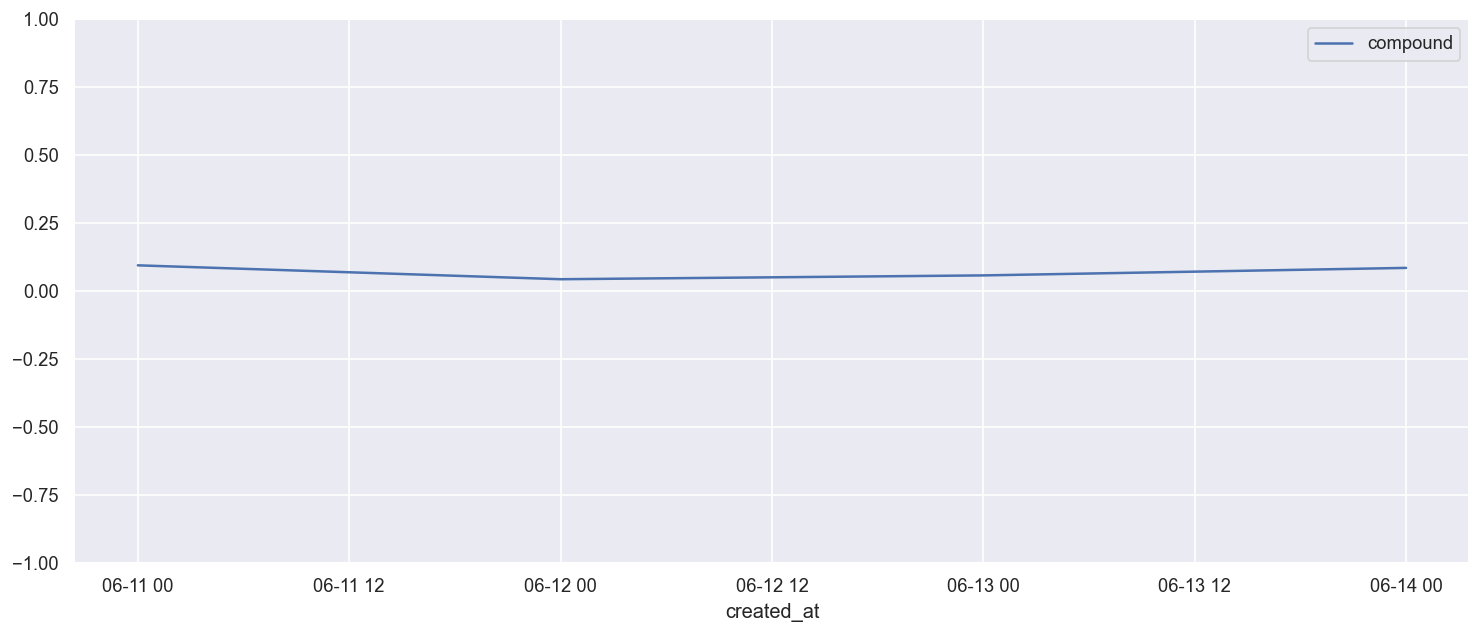

In [254]:
time_series_com.plot(figsize=(15, 6))
plt.ylim((-1,1))
plt.show()

### Cluster Analysis

In [30]:
text_vec = pd.read_csv('cybersec_text_vectorized.csv')
text_vec.head()

,Unnamed: 0,000,002002,0027,003,004,004002,006,00b328bc1cf5221fc6efb560c6bb764922c31e002179799da67f1f68a503ca41,00bytes,...,zta,ztna,zuckerbergstyle,zum,zumbullaw,zurich,zwatest,zwijberg,zyxel,zyz
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
text_vec = text_vec.drop('Unnamed: 0', axis = 1)
text_vec.head()

,000,002002,0027,003,004,004002,006,00b328bc1cf5221fc6efb560c6bb764922c31e002179799da67f1f68a503ca41,00bytes,01,...,zta,ztna,zuckerbergstyle,zum,zumbullaw,zurich,zwatest,zwijberg,zyxel,zyz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
%%time 
range_k = [i for i in range(1, 9)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k, text_vec)
    # 13min 10s

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=6
running Kmeans with k=7
running Kmeans with k=8
CPU times: user 35min 58s, sys: 3min 30s, total: 39min 28s
Wall time: 13min 10s


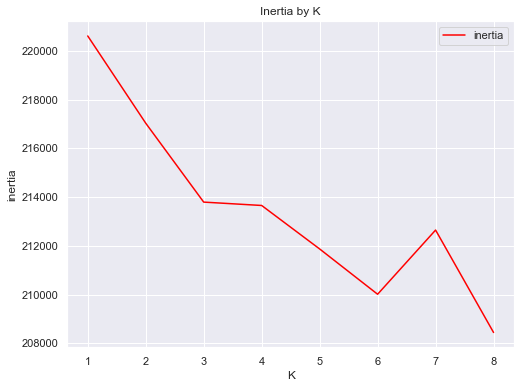

In [50]:
# we can now plot this to see where the inflection point is or where adding more clusters doesnt really add to gaining
# more information from extra clusters

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

In [52]:
%%time
estimator_kmeans = KMeans(random_state=42, n_clusters=6) # making it 6 now to see what happens

estimator_kmeans.fit(text_vec) 

CPU times: user 7min 11s, sys: 29.7 s, total: 7min 41s
Wall time: 2min 12s


KMeans(n_clusters=6, random_state=42)

In [53]:
text_vec["cluster_id"] = estimator_kmeans.labels_
text_vec.head()

,000,002002,0027,003,004,004002,006,00b328bc1cf5221fc6efb560c6bb764922c31e002179799da67f1f68a503ca41,00bytes,01,...,ztna,zuckerbergstyle,zum,zumbullaw,zurich,zwatest,zwijberg,zyxel,zyz,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [54]:
text_clusters = text_vec.groupby('cluster_id').sum()
text_clusters.head()

,000,002002,0027,003,004,004002,006,00b328bc1cf5221fc6efb560c6bb764922c31e002179799da67f1f68a503ca41,00bytes,01,...,zta,ztna,zuckerbergstyle,zum,zumbullaw,zurich,zwatest,zwijberg,zyxel,zyz
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.0,6.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0


In [56]:
text_clusters_20 = text_clusters[['data', 'new', 'attack', 'infosec', 'ransomware', 'amp', 'business', 'us', 'threat', 'hacker', 'ai', 'hacking', 'cyberattack', 'company', 'learn', 'risk', '2021', 'ethicalhacking', 'cloud', 'cybersecuritytips', 'cybersecuritynews', 'iotcybersec24', 'help', 'system', 'need']]
text_clusters_20.head() # only focusing on top 20 post popular words ('u' not in data frame oddly)

,data,new,attack,infosec,ransomware,amp,business,threat,hacker,ai,...,risk,2021,ethicalhacking,cloud,cybersecuritytips,cybersecuritynews,iotcybersec24,help,system,need
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,42.0,46.0,153.0,50.0,29.0,20.0,34.0,34.0,103.0,12.0,...,18.0,22.0,8.0,6.0,2.0,5.0,0.0,9.0,36.0,14.0
1,29.0,47.0,408.0,117.0,1075.0,56.0,70.0,166.0,70.0,7.0,...,40.0,25.0,0.0,8.0,2.0,1.0,0.0,45.0,19.0,34.0
2,1278.0,63.0,51.0,110.0,55.0,120.0,135.0,53.0,129.0,57.0,...,44.0,34.0,3.0,74.0,6.0,2.0,0.0,36.0,64.0,47.0
3,67.0,114.0,4.0,41.0,219.0,11.0,10.0,8.0,24.0,377.0,...,0.0,9.0,1.0,35.0,0.0,0.0,0.0,2.0,4.0,8.0
4,0.0,1065.0,713.0,581.0,0.0,752.0,690.0,553.0,483.0,316.0,...,489.0,572.0,30.0,419.0,26.0,11.0,0.0,468.0,386.0,421.0


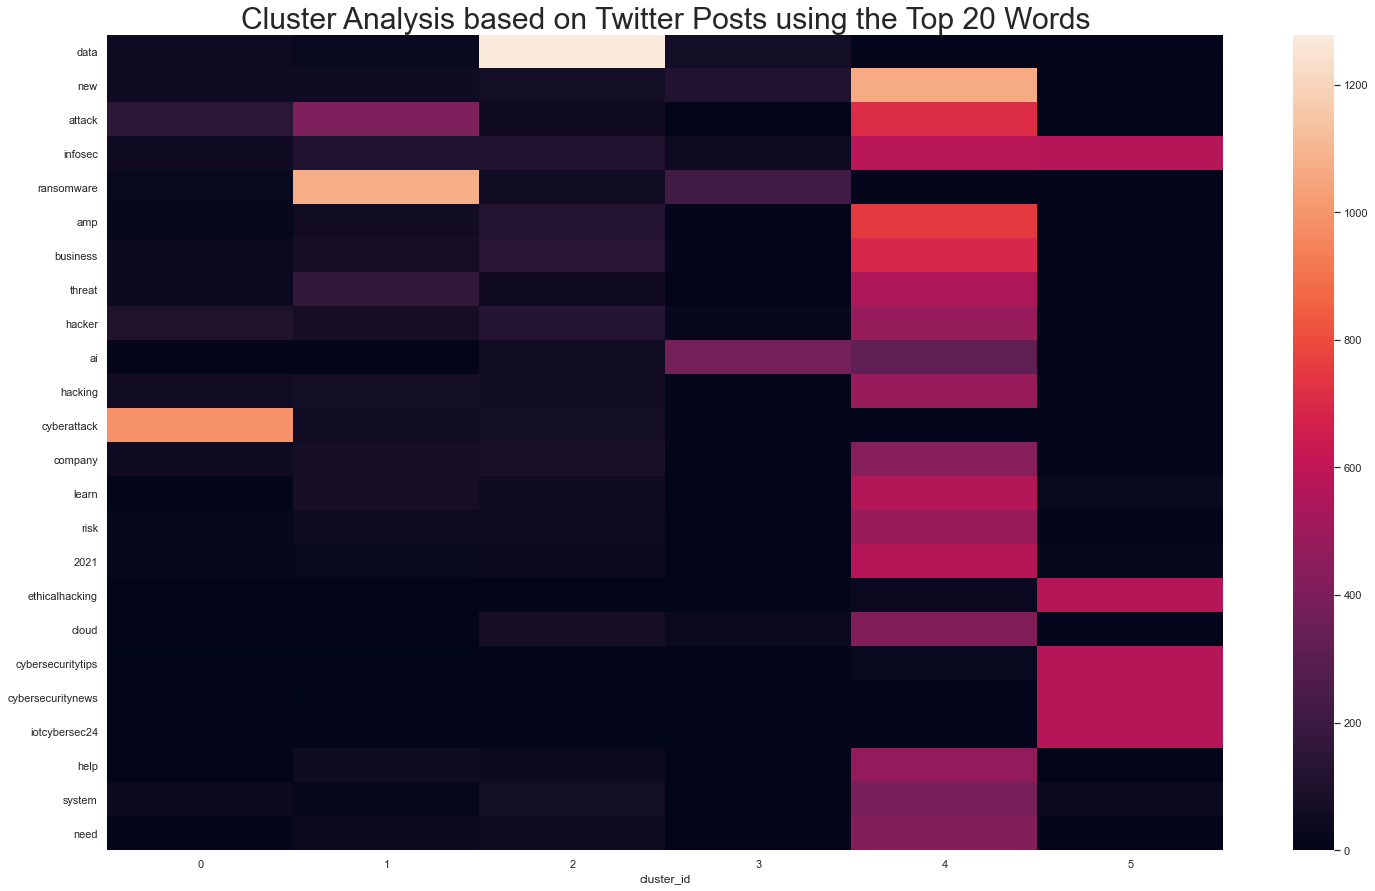

In [58]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(text_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Posts using the Top 20 Words", size = 30);
# Look for rows with a lot of variation to see defining features

**Key Take Aways**

1. Group where data is most commonly used in tweets
2. Group where attack, ethicalhacking, cybersecuritytips, and iotcybersec24 are most commonly used 

## Indentifying Variable Analysis

In [31]:
desc = pd.read_csv('cybersec_processed.csv')[['description', 'user_id']].drop_duplicates('user_id')
desc.head().set_index('user_id')

,description
user_id,
x109082290,leader news hacker hacking techjobs nationalcy...
x194297917,gregory evans mogul founder nationalcybersecur...
x1404297347950071818,NaN
x4439325029,NaN
x821567125785612288,iiotworld first global digitalpublication focu...


In [68]:
user_id = desc[['user_id']].reset_index().drop('index', axis = 1)
user_id

,user_id
0,x109082290
1,x194297917
2,x1404297347950071818
3,x4439325029
4,x821567125785612288
...,...
7631,x14478142
7632,x2491363200
7633,x928636804487622656
7634,x380464757


In [32]:
desc.shape

(7636, 2)

### Word Frequency | Description

In [33]:
desc_words = []

for row in desc['description']:
    for word in str(row).split(" "):
        desc_words.append(word)
        
desc_words[:5]

['leader', 'news', 'hacker', 'hacking', 'techjobs']

In [34]:
len(desc_words)

76925

In [35]:
desc_words = [word for word in desc_words if word != 'nan']
len(desc_words)

76306

In [36]:
fdist_desc = FreqDist()
for word in desc_words:
    fdist_desc[word]+=1
fdist_desc

FreqDist({'business': 713, 'technology': 616, 'service': 561, 'solution': 559, 'news': 447, 'data': 369, 'tech': 369, 'digital': 368, 'cloud': 291, 'company': 283, ...})

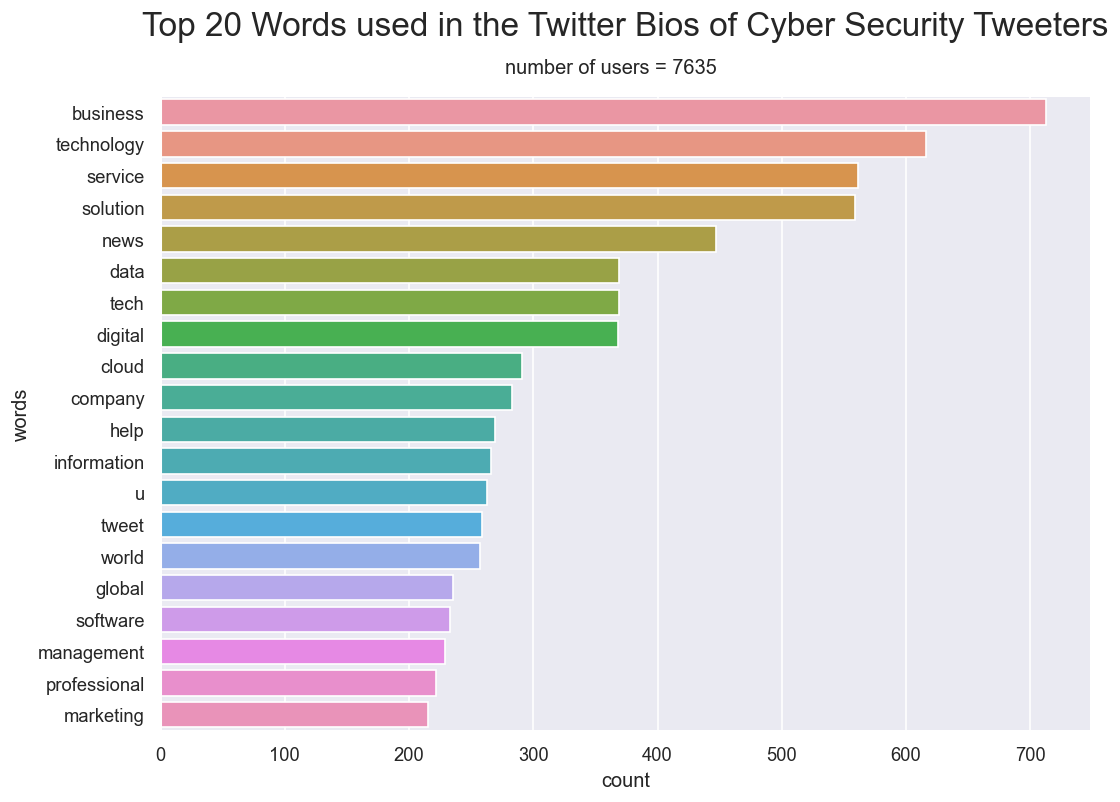

In [739]:
freq_data_desc = pd.DataFrame.from_dict(fdist_desc.most_common(20))
sns.barplot(data = freq_data_desc, x = 1, y = 0)
plt.title("Top 20 Words used in the Twitter Bios of Cyber Security Tweeters", size = 20, y = 1.08)
plt.suptitle("number of users = 7635", y = .925)
plt.xlabel("count")
plt.ylabel("words");

**Main Take Aways**
1. Most of these words deal with business or someone trying to sell a service

In [ ]:
most_common_desc = []

for key in fdist_desc.most_common(20):
    most_common_desc.append(key[0])
    
print(most_common_desc)

### Cluster Analysis | Description

In [60]:
%%time
desc_vec = pd.read_csv('cybersec_desc_vectorized.csv')
desc_vec.head()
# 3min 17s

CPU times: user 1min 15s, sys: 3.41 s, total: 1min 18s
Wall time: 1min 19s


,Unnamed: 0,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,...,àrea,área,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
desc_vec = desc_vec.drop("Unnamed: 0", axis = 1)
desc_vec.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,àrea,área,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
%%time 
range_k = [i for i in range(1, 10)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k, desc_vec)
    # 3min 44s

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=6
running Kmeans with k=7
running Kmeans with k=8
running Kmeans with k=9
CPU times: user 13min 55s, sys: 36.7 s, total: 14min 31s
Wall time: 3min 33s


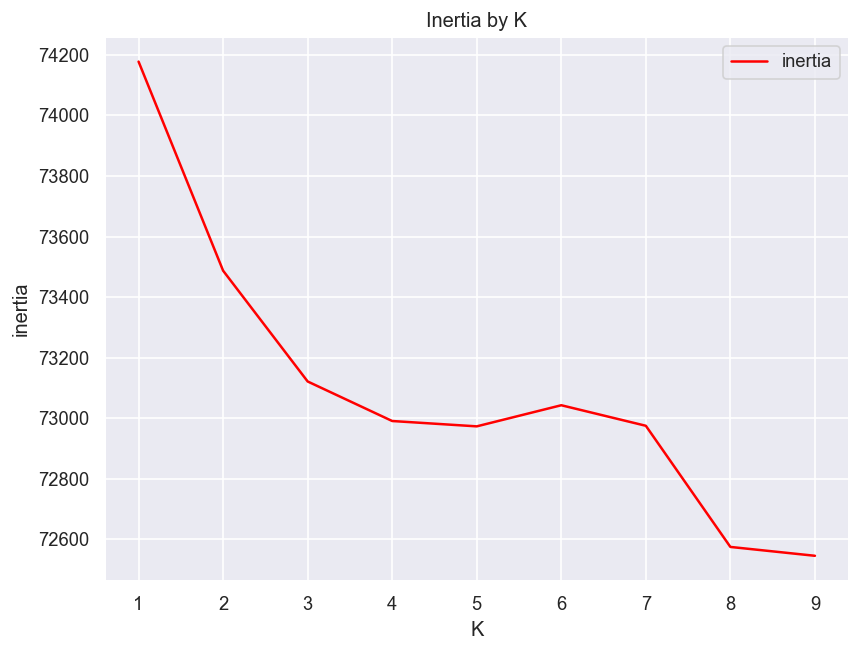

In [63]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

In [64]:
estimator_kmeans = KMeans(random_state=42, n_clusters=8) # 5 for now (the elbow curve is janky)

estimator_kmeans.fit(desc_vec)

KMeans(random_state=42)

In [69]:
desc_vec["cluster_id"] = estimator_kmeans.labels_
desc_vec["user_id"] = user_id['user_id']
desc_vec

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,x109082290
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x194297917
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x1404297347950071818
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x4439325029
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x821567125785612288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x1197561022371905536
7631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x14478142
7632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x2491363200
7633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,x928636804487622656


In [71]:
desc_clusters = desc_vec.groupby('cluster_id').sum()
desc_clusters.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,àrea,área,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
desc_clusters_20 = desc_clusters[['business', 'technology', 'service', 'solution', 'news', 'data', 'tech', 'digital', 'cloud', 'company', 'help', 'information', 'tweet', 'world', 'global', 'software', 'management', 'professional', 'marketing']]

desc_clusters_20

,business,technology,service,solution,news,data,tech,digital,cloud,company,help,information,tweet,world,global,software,management,professional,marketing
cluster_id,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25.0,108.0,416.0,429.0,1.0,60.0,21.0,47.0,85.0,87.0,35.0,34.0,6.0,30.0,42.0,51.0,52.0,41.0,18.0
3,44.0,46.0,22.0,4.0,404.0,15.0,39.0,19.0,15.0,5.0,1.0,40.0,11.0,29.0,20.0,7.0,6.0,12.0,4.0
4,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,332.0,0.0,0.0,0.0,211.0,254.0,232.0,145.0,142.0,169.0,159.0,189.0,177.0,136.0,138.0,132.0,145.0,152.0
7,573.0,97.0,73.0,99.0,2.0,28.0,40.0,45.0,27.0,43.0,59.0,24.0,8.0,18.0,29.0,27.0,29.0,17.0,27.0


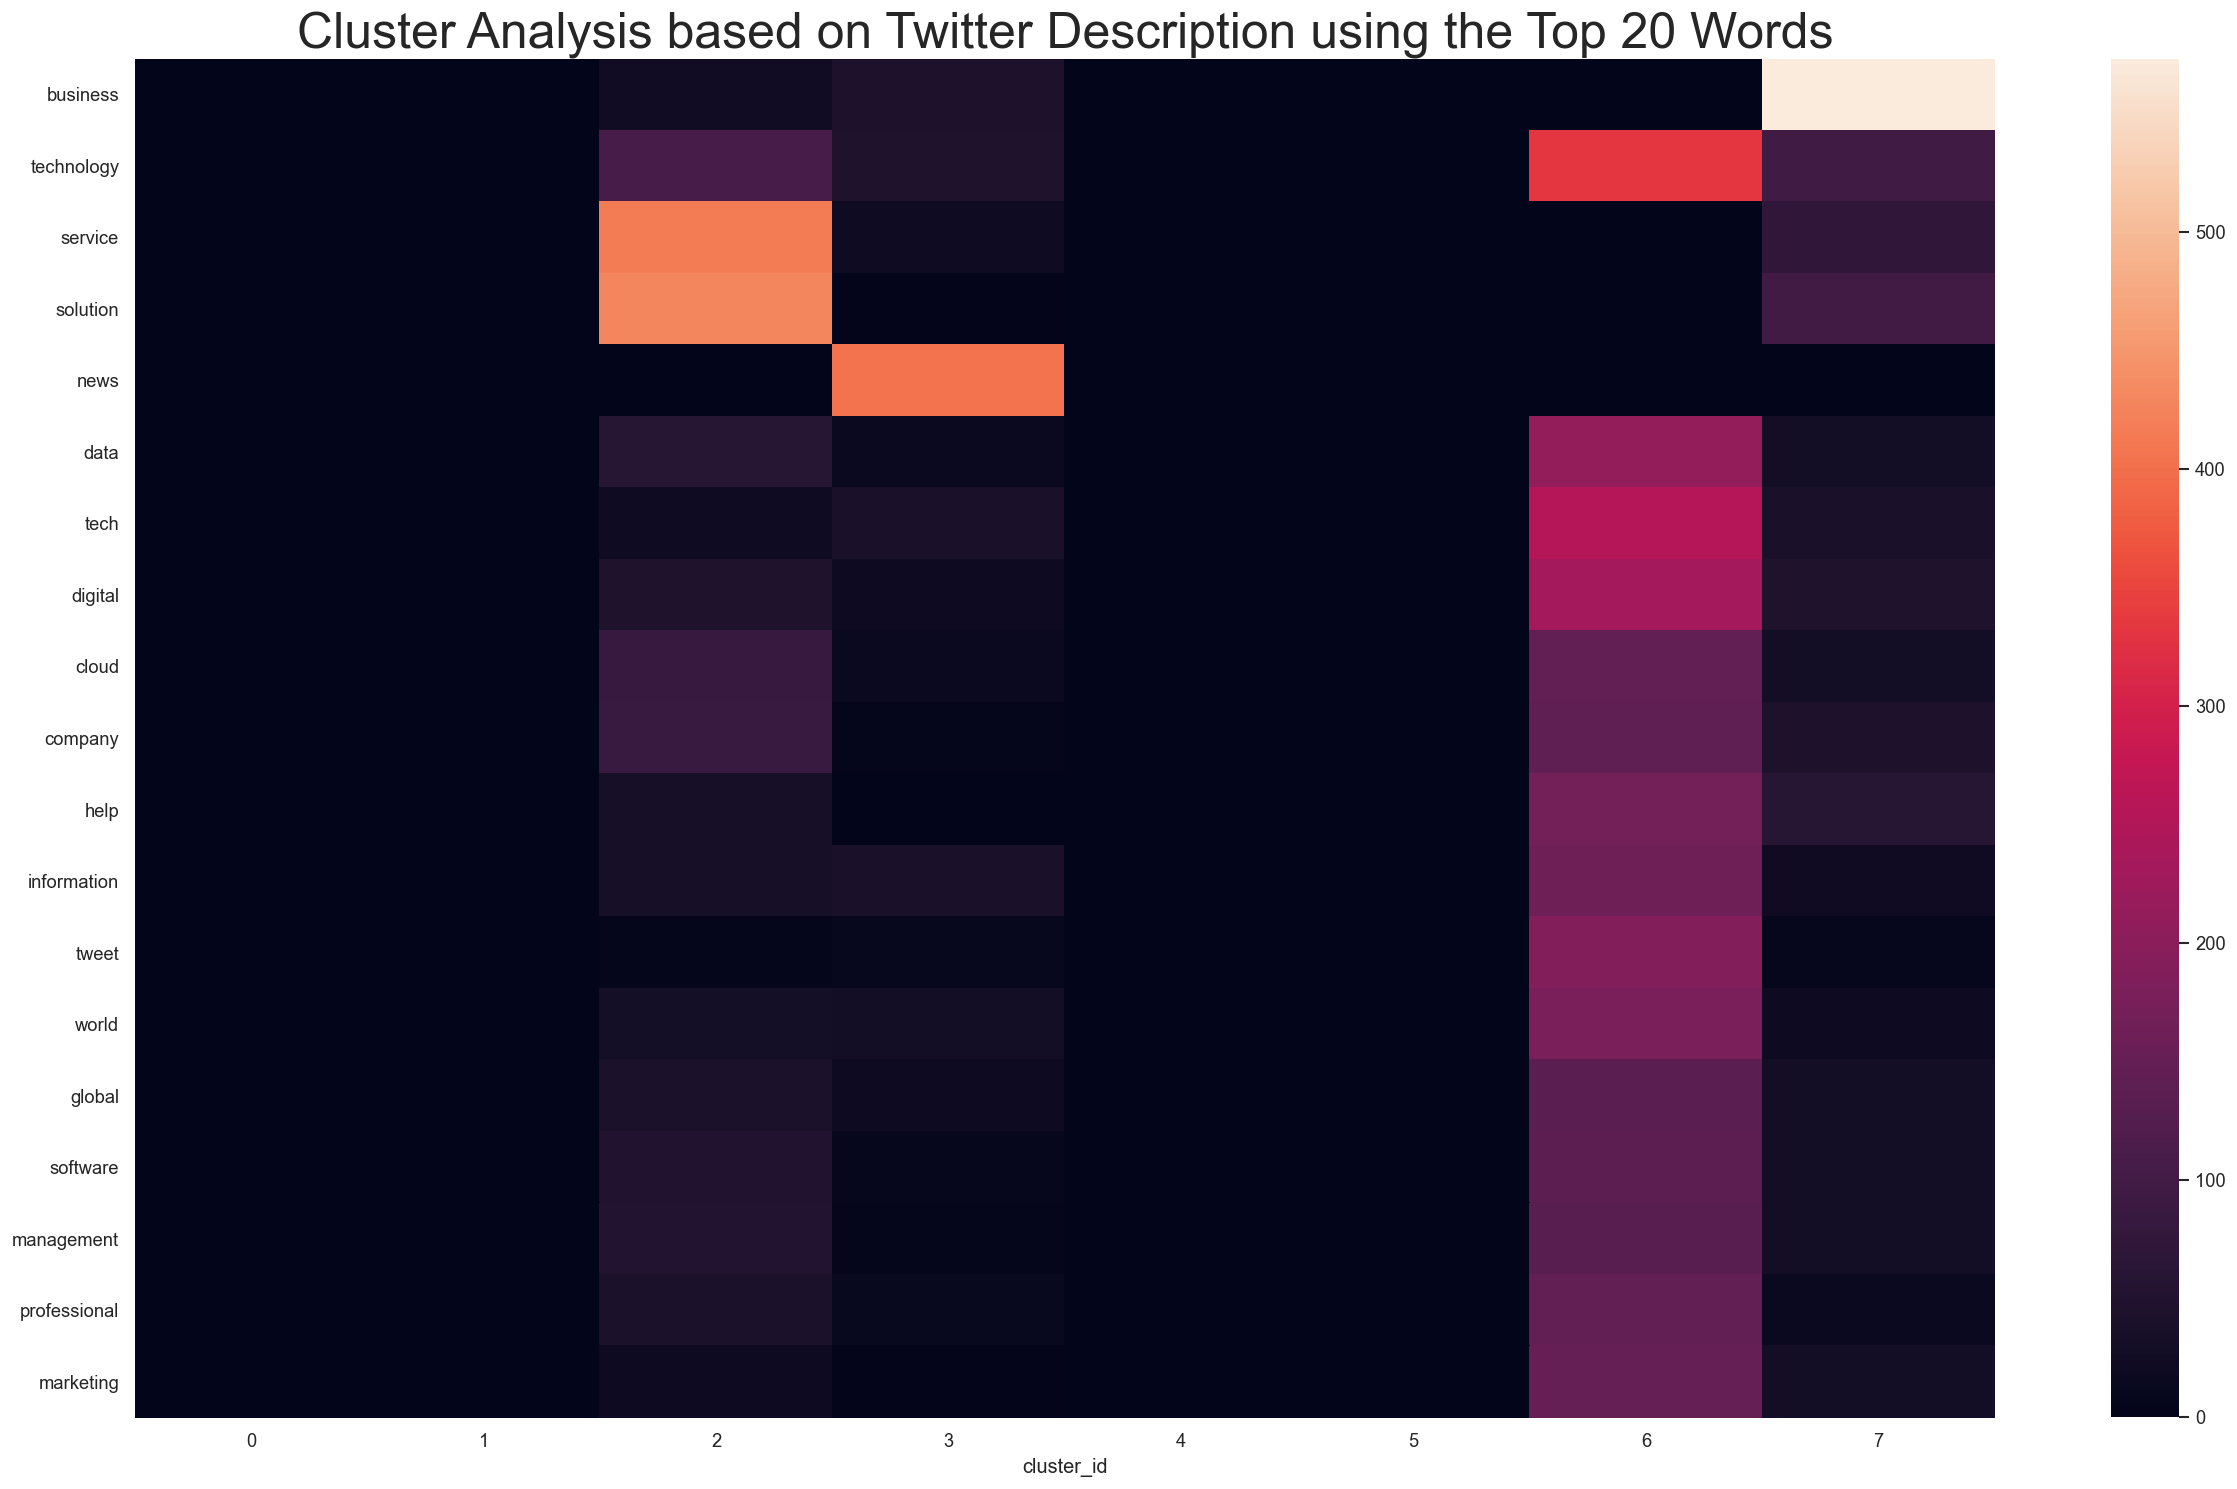

In [73]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(desc_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Description using the Top 20 Words", size = 30);
# Look for rows with a lot of variation to see defining features

#### Cluster 0 

1. Consists of few words that are among the most common words (just one person lol yikes)

In [101]:
cluster_0 = desc_vec[desc_vec.cluster_id == 0]
cluster_0.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
1528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,x1006334607946649600


In [105]:
print(mainWords(cluster_0.drop('user_id', axis = 1).drop('cluster_id', axis = 1)))

['armed', 'cause', 'conflict', 'highlight', 'hot', 'humanitarian', 'news', 'photography', 'photojournalism', 'side', 'spot', 'take', 'today', 'walk', 'wild', 'world']


#### Cluster 1

1. Consists of few words that are among the most common words (just one person lol yikes)

In [103]:
cluster_1 = desc_vec[desc_vec.cluster_id == 1]
cluster_1.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,x1233005242515677185


In [104]:
mainWords(cluster_1.drop('user_id', axis = 1).drop('cluster_id', axis = 1))

['areu270au2764u270cufe0f',
 'mandela',
 'nelson',
 'nmu',
 'u2764ufe0f',
 'ubuntu',
 'uniu0001f4dau0001f58a']

#### Cluster 2

1. Consists of solution and service
2. 743 individuals
2. Sentiments more neutral than overall

In [110]:
cluster_2 = desc_vec[desc_vec.cluster_id == 2]
cluster_2.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,x211329040
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,x943529062856822784
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,x43492898
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,x28859710
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,x2467563638


In [111]:
cluster_2.shape

(743, 18913)

In [112]:
mainWords(cluster_2.drop('user_id', axis = 1).drop('cluster_id', axis = 1))

['service', 'solution']

In [171]:
cluster_2_text = findText(cluster_2)
cluster_2_text.reset_index
len(cluster_2_text.user_id.unique())

743

In [172]:
cluster_2_text.head()

,text,user_id
0,ai act public health tool covid19 policymakers...,x211329040
1,effort get boost federal level moodysinvsvc sa...,x211329040
4,9727 u0001f448\r\ncybersecurity law iotcyberse...,x943529062856822784
5,2999 u0001f448\r\npriceecasting model global x...,x943529062856822784
6,2999 u0001f448\r\nlinux beginner complete guid...,x943529062856822784


In [194]:
sid = SentimentIntensityAnalyzer()
cluster_2_text['scores'] = cluster_2_text['text'].apply(lambda review: sid.polarity_scores(str(review)))
cluster_2_text['compound']  = cluster_2_text['scores'].apply(lambda score_dict: score_dict['compound'])
cluster_2_text['comp_score'] = cluster_2_text['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
cluster_2_text.head()

,text,user_id,scores,compound,comp_score
0,ai act public health tool covid19 policymakers...,x211329040,"{'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'comp...",0.6908,pos
1,effort get boost federal level moodysinvsvc sa...,x211329040,"{'neg': 0.151, 'neu': 0.634, 'pos': 0.215, 'co...",0.3182,pos
4,9727 u0001f448\r\ncybersecurity law iotcyberse...,x943529062856822784,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
5,2999 u0001f448\r\npriceecasting model global x...,x943529062856822784,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
6,2999 u0001f448\r\nlinux beginner complete guid...,x943529062856822784,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral


In [279]:
cluster_2_text.shape

(2081, 5)

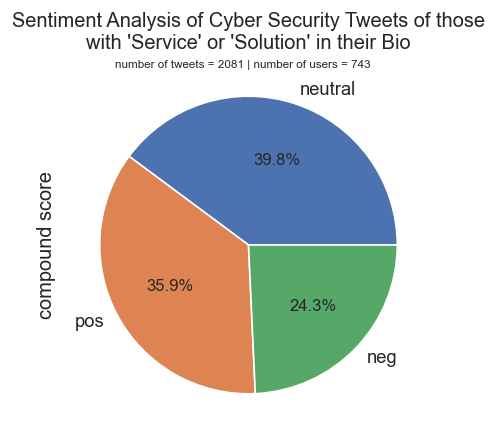

In [298]:
fig, ax = plt.subplots(figsize=(4,6))
comp_score_counts_c2 = cluster_2_text.comp_score.value_counts()
comp_score_counts_c2.plot.pie(autopct="%.1f%%")
plt.title("Sentiment Analysis of Cyber Security Tweets of those" + "\n" + "with 'Service' or 'Solution' in their Bio")
plt.ylabel("compound score")
plt.suptitle('number of tweets = 2081 | number of users = 743', size = 7, y = .76);

#### Cluster 3

1. Consists of news
2. 404 indivuals
2. Sentiments more neutral than overall

In [178]:
cluster_3 = desc_vec[desc_vec.cluster_id == 3]
cluster_3.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,x109082290
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,x337015409
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,x149109780
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,x624973600
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,x18454808


In [179]:
cluster_3.shape

(404, 18913)

In [180]:
mainWords(cluster_3.drop('user_id', axis = 1).drop('cluster_id', axis = 1))

['news']

In [181]:
cluster_3_text = findText(cluster_3)
cluster_3_text.reset_index
len(cluster_3_text.user_id.unique()) #missing 1, help

403

In [305]:
cluster_3_text.shape

(1575, 5)

In [182]:
sid = SentimentIntensityAnalyzer()
cluster_3_text['scores'] = cluster_3_text['text'].apply(lambda review: sid.polarity_scores(str(review)))
cluster_3_text['compound']  = cluster_3_text['scores'].apply(lambda score_dict: score_dict['compound'])
cluster_3_text['comp_score'] = cluster_3_text['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
cluster_3_text.head()

,text,user_id,scores,compound,comp_score
0,sign cause solution network data breach cyber...,x109082290,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp...",0.3182,pos
1,battling chinese big tech encroachment india ...,x109082290,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",-0.2732,neg
2,ask dr jeanette success way devil choke chain ...,x109082290,"{'neg': 0.256, 'neu': 0.55, 'pos': 0.194, 'com...",-0.4404,neg
3,threat digital pakistan cyberattack,x109082290,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'comp...",-0.5267,neg
4,pakistan attack news pakistan army claim major...,x109082290,"{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compou...",-0.7351,neg


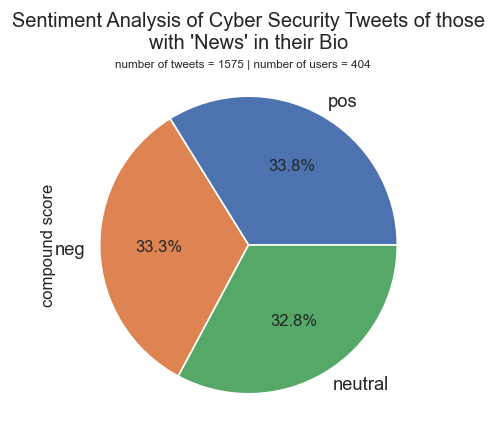

In [308]:
fig, ax = plt.subplots(figsize=(4,6))
comp_score_counts_c3 = cluster_3_text.comp_score.value_counts()
comp_score_counts_c3.plot.pie(autopct="%.1f%%")
plt.title("Sentiment Analysis of Cyber Security Tweets of those" + "\n" + "with 'News' in their Bio")
plt.ylabel("compound score", size = 10)
plt.suptitle('number of tweets = 1575 | number of users = 404', size = 7, y = .76);

#### Cluster 4 

1. Consists of few words that are among the most common words (just 2 people)

In [184]:
cluster_4 = desc_vec[desc_vec.cluster_id == 4]
cluster_4.head()`

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
1941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,x140429955
7490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,x3300689862


In [186]:
print(mainWords(cluster_4.drop('user_id', axis = 1).drop('cluster_id', axis = 1)))

['consultant', 'credential', 'cybersecurityproject', 'e3zine', 'global', 'independent', 'management', 'news', 'outlet', 'partner', 'pro', 'professional', 'project', 'sap', 'scene', 'tech', 'user']


#### Cluster 5 

1. Consists of few words that are among the most common words (just 1 person)

In [187]:
cluster_5 = desc_vec[desc_vec.cluster_id == 5]
cluster_5.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
2336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,x1188102517793665024


In [188]:
print(mainWords(cluster_5.drop('user_id', axis = 1).drop('cluster_id', axis = 1)))

['america', 'business', 'cmit', 'company', 'dedicated', 'delivering', 'enterpriseclass', 'medium', 'north', 'premier', 'size', 'small', 'solution', 'support']


#### Cluster 6 

1. Least cohesive group,there are no words that atlest 10% of people share in their bios
2. 5910 individual people

In [189]:
cluster_6 = desc_vec[desc_vec.cluster_id == 6]
cluster_6.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x194297917
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x1404297347950071818
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x4439325029
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x821567125785612288
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,x953682855372009472


In [190]:
cluster_6.shape

(5910, 18913)

In [193]:
print(mainWords(cluster_6.drop('user_id', axis = 1).drop('cluster_id', axis = 1)))

[]


#### Cluster 7 

1. Mainly have business in their bios
2. 573 individual people

In [196]:
cluster_7 = desc_vec[desc_vec.cluster_id == 7]
cluster_7.head()

,001,0099,01,01100101,01100111,01101000,01101111,01110010,01110100,0121,...,économique,énfasis,ético,ïgh,ïñ,ñuñoando,österreich,þlåïñ,cluster_id,user_id
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,x1148956785858007041
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,x3003618794
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,x823901300236648448
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,x319207370
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,x125913124


In [197]:
cluster_7.shape

(573, 18913)

In [200]:
print(mainWords(cluster_7.drop('user_id', axis = 1).drop('cluster_id', axis = 1)))

['business']


In [202]:
cluster_7_text = findText(cluster_7)
cluster_7_text.reset_index
len(cluster_7_text.user_id.unique()) 

573

In [203]:
sid = SentimentIntensityAnalyzer()
cluster_7_text['scores'] = cluster_7_text['text'].apply(lambda review: sid.polarity_scores(str(review)))
cluster_7_text['compound']  = cluster_7_text['scores'].apply(lambda score_dict: score_dict['compound'])
cluster_7_text['comp_score'] = cluster_7_text['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
cluster_7_text.head()

,text,user_id,scores,compound,comp_score
0,join live podcast learn property popia act com...,x1148956785858007041,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",0.2960,pos
1,ad\r\ncyber unravelled day left popi act compl...,x1148956785858007041,"{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'comp...",0.2960,pos
4,wondering long take hacker start exploiting pa...,x3003618794,"{'neg': 0.141, 'neu': 0.728, 'pos': 0.131, 'co...",-0.0516,neg
5,cloud many strategic advantage business especi...,x3003618794,"{'neg': 0.0, 'neu': 0.882, 'pos': 0.118, 'comp...",0.2500,pos
8,ransomware attack rise could surpass 265 billi...,x823901300236648448,"{'neg': 0.197, 'neu': 0.637, 'pos': 0.166, 'co...",-0.1280,neg


In [309]:
cluster_7_text.shape

(1163, 5)

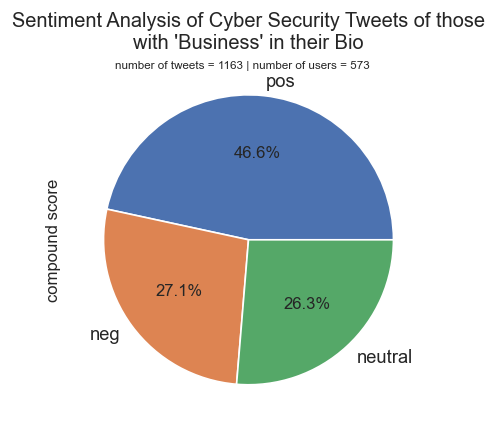

In [314]:
fig, ax = plt.subplots(figsize=(4,4))
comp_score_counts_c7 = cluster_7_text.comp_score.value_counts()
comp_score_counts_c7.plot.pie(autopct="%.1f%%")
plt.title("Sentiment Analysis of Cyber Security Tweets of those" + "\n" + "with 'Business' in their Bio")
plt.ylabel("compound score", size = 10)
plt.suptitle('number of tweets = 1163 | number of users = 573', size = 7, y = .875);

### Cluster Analysis | Other Columns

#### Processing Data

In [348]:
ident = data[["country", "is_quote", "retweet_count", "followers_count", "friends_count", "listed_count", "verified", "year_account_created"]]
ident.head() # remove is_retweet and protected, no variance

,country,is_quote,retweet_count,followers_count,friends_count,listed_count,verified,year_account_created
0,United States,False,0,8524,157,134.0,False,2010.0
1,United States,False,4,8524,157,134.0,False,2010.0
2,United States,False,3,8524,157,134.0,False,2010.0
3,United States,False,2,8524,157,134.0,False,2010.0
4,United States,False,2,8524,157,134.0,False,2010.0


In [351]:
ident = ident.drop(labels = [4723, 4725, 4727, 4729, 4732, 4734, 4736, 4738], axis = 0)

In [352]:
ident.isna().sum()

country                 0
is_quote                0
retweet_count           0
followers_count         0
friends_count           0
listed_count            0
verified                0
year_account_created    0
dtype: int64

In [353]:
ident['year_account_created'] = ident['year_account_created'].astype("category")
ident['followers_count'] = ident['followers_count'].astype("float64")
ident['friends_count'] = ident['friends_count'].astype("float64")
ident['retweet_count'] = ident['retweet_count'].astype("float64")
ident['age_of_account'] = 2021 - ident['year_account_created'].astype("float64")

In [354]:
ident.dtypes

country                   object
is_quote                  object
retweet_count            float64
followers_count          float64
friends_count            float64
listed_count             float64
verified                  object
year_account_created    category
age_of_account           float64
dtype: object

In [355]:
ident = ident.drop('year_account_created', axis = 1)
ident.head()

,country,is_quote,retweet_count,followers_count,friends_count,listed_count,verified,age_of_account
0,United States,False,0.0,8524.0,157.0,134.0,False,11.0
1,United States,False,4.0,8524.0,157.0,134.0,False,11.0
2,United States,False,3.0,8524.0,157.0,134.0,False,11.0
3,United States,False,2.0,8524.0,157.0,134.0,False,11.0
4,United States,False,2.0,8524.0,157.0,134.0,False,11.0


In [356]:
numerical_data = ident.select_dtypes(np.number)
numerical_data.head()

,retweet_count,followers_count,friends_count,listed_count,age_of_account
0,0.0,8524.0,157.0,134.0,11.0
1,4.0,8524.0,157.0,134.0,11.0
2,3.0,8524.0,157.0,134.0,11.0
3,2.0,8524.0,157.0,134.0,11.0
4,2.0,8524.0,157.0,134.0,11.0


In [357]:
categorical_data = ident.drop(numerical_data, axis = 1)
categorical_data.head()

,country,is_quote,verified
0,United States,False,False
1,United States,False,False
2,United States,False,False
3,United States,False,False
4,United States,False,False


In [358]:
numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
    numerical_data_normalized,
    columns=numerical_data.columns) 

numerical_data_normalized.head()

,retweet_count,followers_count,friends_count,listed_count,age_of_account
0,0.000000,0.000846,0.000389,0.001236,0.733333
1,0.016064,0.000846,0.000389,0.001236,0.733333
2,0.012048,0.000846,0.000389,0.001236,0.733333
3,0.008032,0.000846,0.000389,0.001236,0.733333
4,0.008032,0.000846,0.000389,0.001236,0.733333


In [359]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True,
                                    dtype="int64"
).reset_index()
categorical_data_codified.head()

,index,country_Algérie / ⵍⵣⵣⴰⵢⴻⵔ / الجزائر,country_Argentina,country_Asia,country_Australia,country_Azərbaycan,country_België / Belgique / Belgien,country_Bermuda,country_Bolivia,country_Bosna i Hercegovina / Босна и Херцеговина,...,country_ኢትዮጵያ,country_日本,country_臺灣,country_龙虬庄文化,country_대한민국,country_조선민주주의인민공화국,is_quote_True,verified_True,verified_False,verified_True
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [360]:
categorical_data_codified = categorical_data_codified[['country_United States', 'country_Unknown', 'country_United Kingdom', 'country_India', 'country_Global', 'is_quote_True', 'verified_True', 'verified_False']]
# using only top 5 most common countries

In [361]:
df2_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
).reset_index()

In [363]:
#df2_processed = df2_processed.drop('level_0', axis = 1)
df2_processed = df2_processed.drop('index', axis = 1)
df2_processed = df2_processed.drop('verified_True', axis = 1)
df2_processed.head()


,retweet_count,followers_count,friends_count,listed_count,age_of_account,country_United States,country_Unknown,country_United Kingdom,country_India,country_Global,is_quote_True,verified_False
0,0.000000,0.000846,0.000389,0.001236,0.733333,1,0,0,0,0,0,1
1,0.016064,0.000846,0.000389,0.001236,0.733333,1,0,0,0,0,0,1
2,0.012048,0.000846,0.000389,0.001236,0.733333,1,0,0,0,0,0,1
3,0.008032,0.000846,0.000389,0.001236,0.733333,1,0,0,0,0,0,1
4,0.008032,0.000846,0.000389,0.001236,0.733333,1,0,0,0,0,0,1


#### Analysis

In [364]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k, df2_processed)

running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=30
CPU times: user 14 s, sys: 3.66 s, total: 17.7 s
Wall time: 2.36 s


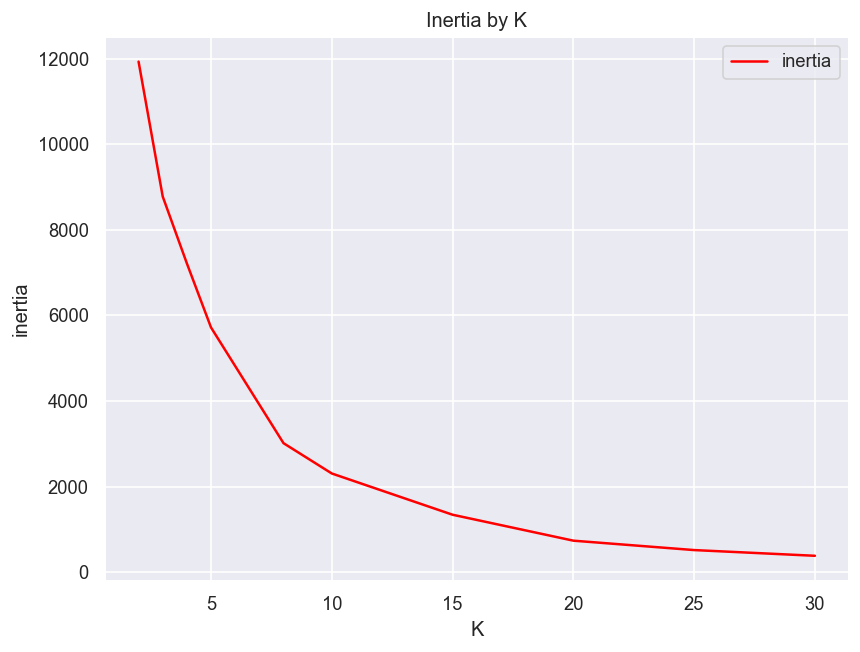

In [365]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

In [373]:
estimator_kmeans = KMeans(random_state=42, n_clusters=7) # 5 for now (the elbow curve is janky)

estimator_kmeans.fit(df2_processed)

KMeans(n_clusters=7, random_state=42)

In [374]:
ident["cluster_id"] = estimator_kmeans.labels_
ident.head()

,country,is_quote,retweet_count,followers_count,friends_count,listed_count,verified,age_of_account,cluster_id
0,United States,False,0.0,8524.0,157.0,134.0,False,11.0,2
1,United States,False,4.0,8524.0,157.0,134.0,False,11.0,2
2,United States,False,3.0,8524.0,157.0,134.0,False,11.0,2
3,United States,False,2.0,8524.0,157.0,134.0,False,11.0,2
4,United States,False,2.0,8524.0,157.0,134.0,False,11.0,2


In [375]:
ident.cluster_id.value_counts()

2    3175
0    3056
3    3002
5    2830
1    2132
6    1894
4    1559
Name: cluster_id, dtype: int64

In [379]:
cluster_comparison(0,1,2,3,4,5,6)

cluster_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0
country,India,Unknown,United States,Unknown,United Kingdom,United States,India
is_quote,0.062173,0.015947,0.021102,0.056296,0.033355,0.037809,0.016367
verified,False,False,False,False,False,False,False
retweet_count,2.997709,4.393058,1.774488,2.516322,2.212957,2.553357,4.110348
followers_count,21218.26767,7543.756567,10014.555591,15800.693871,14724.804362,21614.660071,11471.595565
friends_count,2734.10373,2383.736398,2473.330394,1430.469354,1988.215523,3058.978092,3617.876452
listed_count,294.466296,386.182458,172.514961,227.483344,311.998076,438.667491,592.558606
age_of_account,7.337369,5.214353,8.149606,5.936376,7.524054,8.003534,6.80623


In [380]:
cluster_results = kmeans_cluster(df2_processed, 7)
cluster_summary2 = graph_summary_clustering(cluster_results)

In [381]:
#cluster_summary2 = cluster_summary2.drop('cluster_id', axis = 1)
cluster_summary2

,age_of_account,country_Global,country_India,country_United Kingdom,country_United States,country_Unknown,followers_count,friends_count,is_quote_True,listed_count,retweet_count,verified_False
Cluster,,,,,,,,,,,,
0,0.489158,0.084097,0.213678,0.0,0.0,0.0,0.002107,0.006780,0.062173,0.002717,0.012039,0.000000
1,0.347624,0.000000,0.000000,0.0,0.0,1.0,0.000749,0.005911,0.015947,0.003563,0.017643,1.000000
2,0.543307,0.000000,0.000000,0.0,1.0,0.0,0.000994,0.006133,0.021102,0.001592,0.007126,1.000000
3,0.395758,0.000000,0.000000,0.0,0.0,1.0,0.001569,0.003547,0.056296,0.002099,0.010106,0.000000
4,0.501604,0.000000,0.000000,1.0,0.0,0.0,0.001462,0.004930,0.033355,0.002878,0.008887,0.427197
5,0.533569,0.000000,0.000000,0.0,1.0,0.0,0.002146,0.007585,0.037809,0.004047,0.010254,0.000000
6,0.453749,0.142555,0.172122,0.0,0.0,0.0,0.001139,0.008971,0.016367,0.005467,0.016507,1.000000


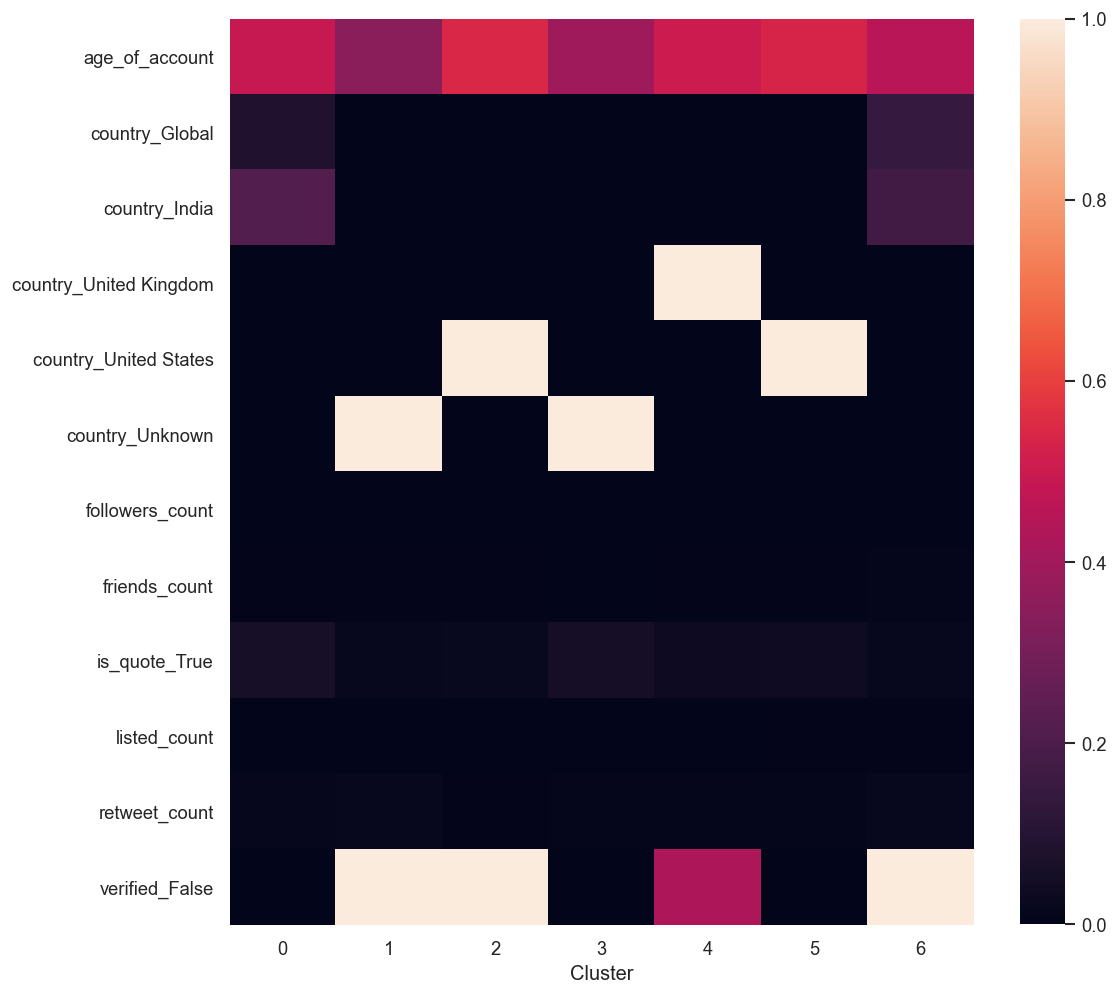

In [382]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary2.transpose(), annot=False);